In [22]:
import pandas as pd

df = pd.read_csv('signals.csv')
freqs = pd.read_csv('unigram_freq.csv')
freqs.columns = ['word', 'freq']

In [23]:
from nltk.stem.lancaster import LancasterStemmer 
stemmer = LancasterStemmer()

freqs['word'] = freqs['word'].map(lambda x: stemmer.stem(str(x)))
freqs['freq'] = freqs.groupby(['word'])['freq'].transform('sum')
freqs = freqs.drop_duplicates()

In [24]:
df['word'] = df['word'].map(lambda x: stemmer.stem(str(x)))

In [25]:
df = df.drop_duplicates()

In [26]:
df = pd.merge(df, freqs, left_on='word', right_on='word', how='inner')

In [27]:
df3 = df.merge(df.loc[df['signal'] == 0.0][['userId', 'word']].drop_duplicates(), on=['userId', 'word'],how='inner')

In [28]:
df = df3.copy()
df = df.sort_values(['time'])
df['oword'] = df['word']
df['diff'] = df.groupby(['userId', 'word'])['time'].diff().fillna(0)
df['diff'] /= (60*60*24)
df['time_min'] = df.groupby(['userId', 'word'])['time'].transform(min)
df['otime'] = df['time']
df['time'] = df['time'] - df['time_min']
# df['csignal'] = df.groupby(['userId', 'word'])['signal'] \
#     .apply(lambda x: x.expanding().mean().shift())
# df['wpm'] = df.groupby(['userId', 'word'])['wpm'] \
#     .apply(lambda x: x.expanding().mean().shift())
df['prev'] = df.groupby(['userId', 'word'])['signal'].shift(1)
df['count'] = df.groupby(['userId', 'word'])\
    .cumcount().add(1)
# df['ccount'] = df.groupby(['userId', 'word'])['count'].transform(max)

In [29]:
import numpy as np 
#df = df.loc[df['userId'].isin(["8ACCQYz8NMc4Lc9Nze3R","0bHdAlU0BUXj4OLRPzTZ","1yz9QcMjyGFMMdC6LPlJ","3dkoVNdFAoch4sxXEtWo","7ksTSrU6NjGGoZqnu7uG","AWJ3AzY0AdAUKDqerSwH","GDQqFBeAkT3BM8LaUf4e","Jj9P1sIqjLLF0wVqDFeX","NdlYszQsqy4y8pKYKj8N","OQJ8K3jcLOM3eYaImkyN","VbFRYXiXVyBLWzGDlqqm","YnCBKw1ZLXEgJ4iU2hK0","ZYTj0ZyUTpLsaxb0zoSB","bmKnPQcO48sDdLAKy5Lu","dlA8HbNeY2c4dyNnK5VL","g11JTV6am9fleET7bIid","mzQZO80m21TM0C7gRcqb","qtW5EhH8cUORCIwwOSiX","xP0QeRM7qCAi1bOSAt1o","zdWiLjoIxRDrtMRNjOlk"])]
#df = df.loc[df['count'] > 1]
df['signal'] = np.where(df['signal'] == 1.0, False, True)

In [30]:
df = df[['signal','eltime','wpm','count', 'time', 'freq']]
y = df.iloc[:, 0]
x = df.iloc[:, 1:]

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)


In [33]:
model2 = AdaBoostClassifier(n_estimators=800, random_state = 1)
model2.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=800, random_state=1)

In [34]:
test_pred = model2.predict_proba(x_test)

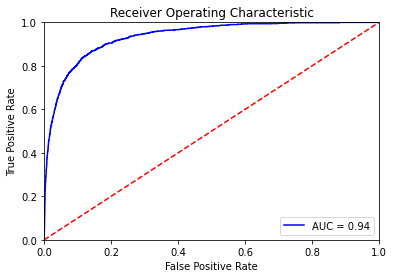

In [36]:
test_pred = model2.predict_proba(x_test)[:,1]
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, recall_score, accuracy_score
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])    
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
test_pred = model2.predict(x_test)
confusion_matrix(y_test, test_pred)

array([[10095,   280],
       [  556,   727]], dtype=int64)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [39]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(x.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

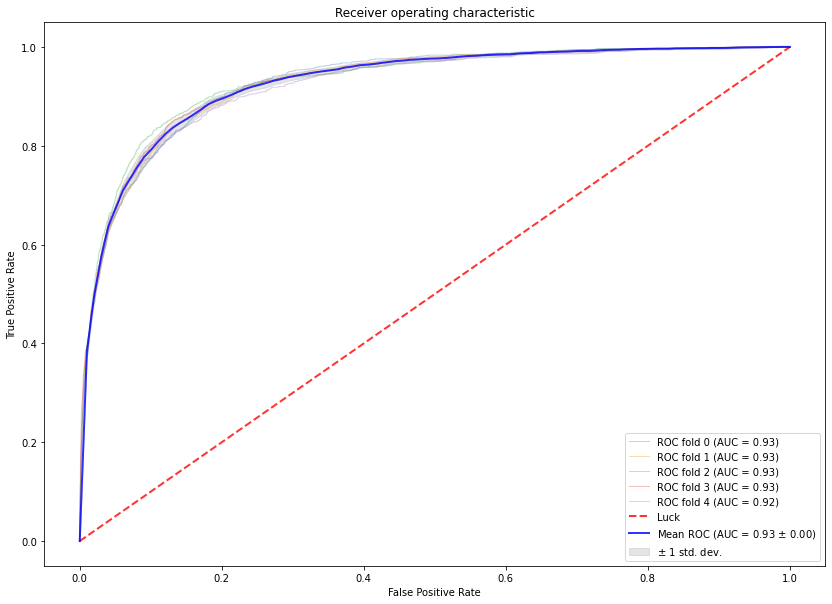

,AUC Train,AUC Test
0,0.931720,0.928379
1,0.931275,0.927473
2,0.930883,0.931319
3,0.931496,0.929072
4,0.933096,0.921500


In [40]:
from sklearn.neural_network import MLPClassifier

clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(x, y), range(5)):
    
    clf.fit(x.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

0.7454546227964223
0.7466653190360363
0.7530647462286255
0.765225749166237
0.7477384995843043


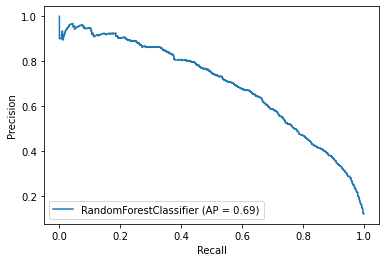

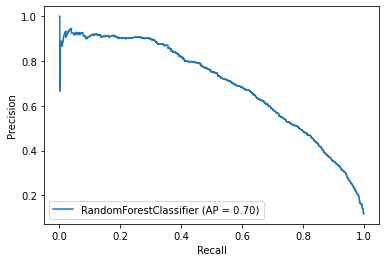

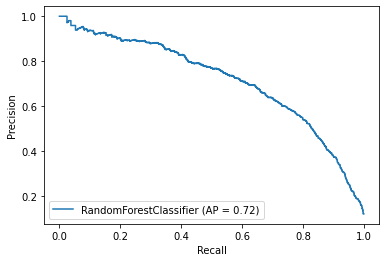

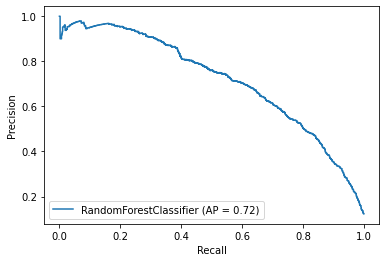

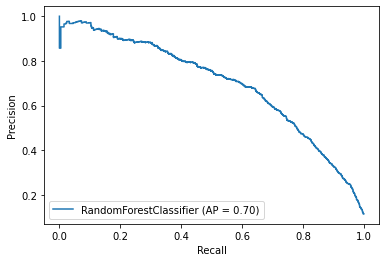

In [42]:
from sklearn.neural_network import MLPClassifier



clf = RandomForestClassifier(
    n_estimators=300,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)
from sklearn.metrics import f1_score
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
for (train, test), i in zip(cv.split(x, y), range(5)):
    clf.fit(x.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    
  
    y_predict = clf.predict_proba(x.iloc[test])[:,1]
    y_predict2 = clf.predict(x.iloc[test])
    print(f1_score(y.iloc[test], y_predict2, average='macro'))
#     fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
   # precision, recall, thresholds = precision_recall_curve(y.iloc[test], y_predict)
    #scores.append((auc_score_train, auc_score))
   # fprs.append(precision)
    plot_precision_recall_curve(clf, x.iloc[test], y.iloc[test])
   # tprs.append(recall)



#from sklearn.metrics import plot_precision_recall_curve
#plot_roc_curve(fprs, tprs);